In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d lavaman151/plantifydr-dataset

100% 2.58G/2.58G [02:12<00:00, 23.7MB/s]
100% 2.58G/2.58G [02:12<00:00, 20.9MB/s]


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/plantifydr-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [ ]:
#Generator
train_data = keras.utils.image_dataset_from_directory(
    directory = '/content/PlantDiseasesDataset/Apple/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)

)
test_data = keras.utils.image_dataset_from_directory(
    directory = '/content/PlantDiseasesDataset/Apple/valid',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 13124 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


In [ ]:
class_names = train_data.class_names
class_names

['Apple Black rot', 'Apple Healthy', 'Apple Scab', 'Cedar apple rust']

In [ ]:
len(train_data)

411

In [ ]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 3 0 3 2 1 2 2 2 1 0 2 1 3 2 1 1 3 2 2 2 1 2 2 0 2 2 1 1 3 3]


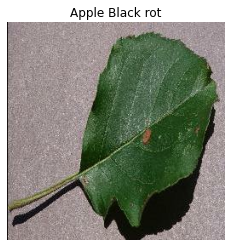

In [ ]:
import matplotlib.pyplot as plt
for image_batch, label_batch in train_data.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[label_batch[0]])
  plt.axis('off')

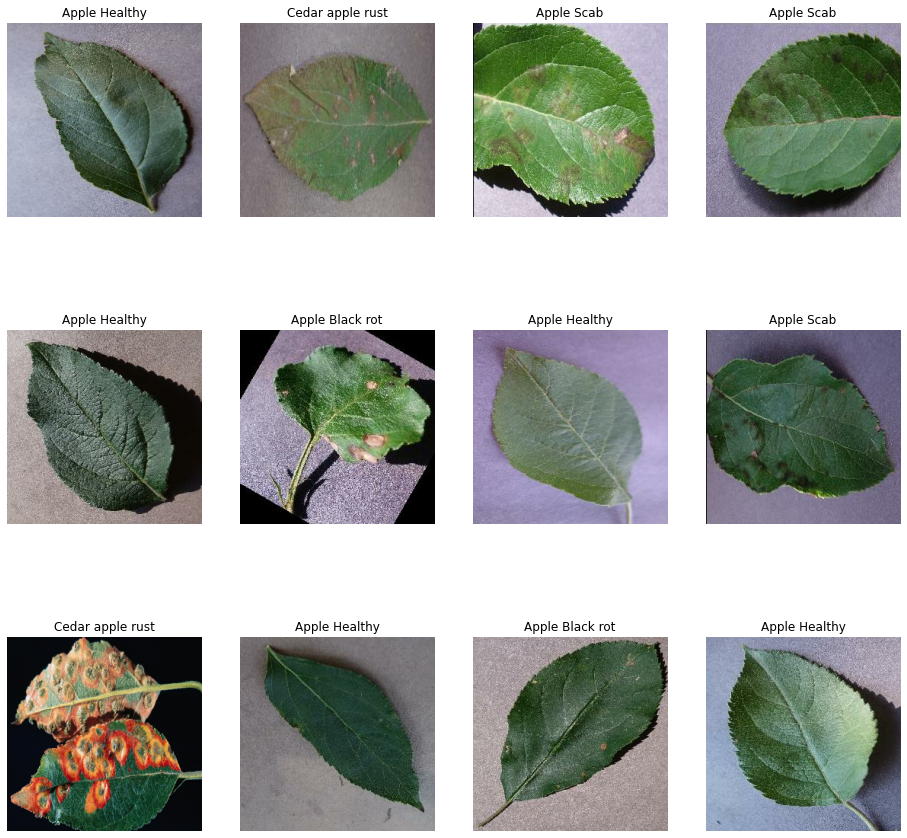

In [ ]:
plt.figure(figsize=(16,16))
for image_batch, label_batch in train_data.take(1):
  for i in range (12):
    leaf = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [ ]:
len(train_data)

411

In [ ]:
len(test_data)

2

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])
# data preprocessing completes here

In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])
model.build(input_shape = (32,256,256,3))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs = 5,
    batch_size = 32,
    verbose = 1,

)

Epoch 1/5
411/411 [==============================] - 57s 114ms/step - loss: 0.7061 - accuracy: 0.7018
Epoch 2/5
411/411 [==============================] - 46s 111ms/step - loss: 0.2961 - accuracy: 0.8962
Epoch 3/5
411/411 [==============================] - 46s 111ms/step - loss: 0.1678 - accuracy: 0.9420
Epoch 4/5
411/411 [==============================] - 47s 114ms/step - loss: 0.1466 - accuracy: 0.9497
Epoch 5/5
411/411 [==============================] - 47s 114ms/step - loss: 0.1013 - accuracy: 0.9668


In [ ]:
scores= model.evaluate(test_data)

2/2 [==============================] - 1s 203ms/step - loss: 1.0799 - accuracy: 0.6250


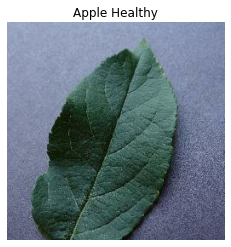

In [ ]:
for image_batch , label_batch in train_data.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[label_batch[0]])
  plt.axis('off')

The image to predict
Actual_label: Cedar apple rust
1/1 [==============================] - 0s 137ms/step
Predicted label: Cedar apple rust


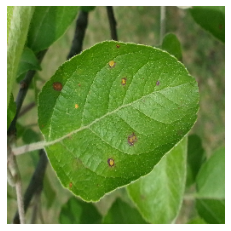

In [ ]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print('The image to predict')
  plt.imshow(first_image)
  print('Actual_label:', class_names[first_label])

  batch_prediction = model.predict(image_batch)
  pred_label = np.argmax(batch_prediction[0])
  print('Predicted label:', class_names[pred_label])
  plt.axis('off')

In [ ]:
def predict (model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) # create a batch

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class , confidence

1/1 [==============================] - 0s 16ms/step


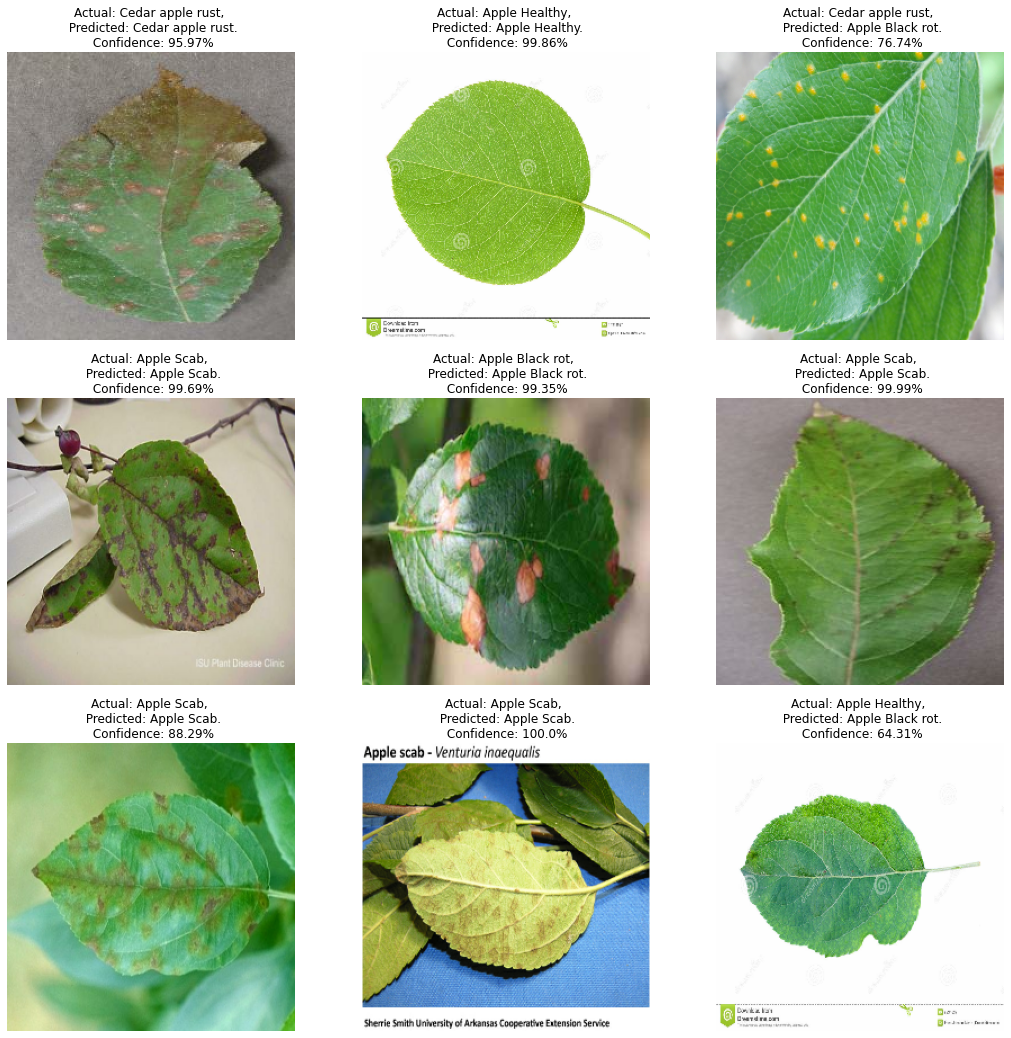

In [ ]:
plt.figure(figsize=(18,18))
for images, labels in test_data.take(1):
  for i in range (9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class , confidence = predict(model,images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%')

    plt.axis('off')


In [ ]:
tf.keras.models.save_model(model, 'apple.pbtxt')
converter = tf.lite.TFLiteConverter.from_keras_model(model = model)
model_tflite = converter.convert()
open("AppleDisease.tflite","wb").write(model_tflite)

741920